In [69]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# Données
import wrds

In [70]:
# Enlever tous les messages de prévention sous les résultats 
import warnings
warnings.filterwarnings('ignore')

## Préparation des données DEVISES

In [71]:
currencies = pd.read_csv('currencies.csv')
currencies['date'] = pd.to_datetime(currencies['date'])

currencies

,date,dexalus,dexcaus,dexjpus,dexszus,dexukus
0,2000-01-03,1.517220,1.4465,101.70,1.5808,0.614628
1,2000-01-04,1.523926,1.4518,103.09,1.5565,0.610874
2,2000-01-05,1.526718,1.4518,103.77,1.5526,0.609199
3,2000-01-06,1.529052,1.4571,105.19,1.5540,0.606980
4,2000-01-07,1.527184,1.4505,105.17,1.5623,0.610352
...,...,...,...,...,...,...
6517,2024-12-25,NaN,NaN,NaN,NaN,NaN
6518,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
6519,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
6520,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [76]:
# Renommer colonnes
currencies.columns = ['date', 'Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
currencies

,date,Australia,Canada,Japan,Switzerland,UK
0,2000-01-03,1.517220,1.4465,101.70,1.5808,0.614628
1,2000-01-04,1.523926,1.4518,103.09,1.5565,0.610874
2,2000-01-05,1.526718,1.4518,103.77,1.5526,0.609199
3,2000-01-06,1.529052,1.4571,105.19,1.5540,0.606980
4,2000-01-07,1.527184,1.4505,105.17,1.5623,0.610352
...,...,...,...,...,...,...
6517,2024-12-25,NaN,NaN,NaN,NaN,NaN
6518,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
6519,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
6520,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [78]:
# Nettoyage + fréquence données 

currencies_daily = currencies.dropna()

print(f"Nombre observations avant nettoyage : {len(currencies)}")
print(f"Nombre observations après nettoyage : {len(currencies_daily)}")
print(f"Nombre observations supprimées : {len(currencies) - len(currencies_daily)}")

print(f"\nDate de début : {currencies_daily['date'].min()}")
print(f"Date de fin : {currencies_daily['date'].max()}\n")
print(f"Durée totale : {(currencies_daily['date'].max() - currencies_daily['date'].min()).days} jours\n")

currencies_daily.info()

Nombre observations avant nettoyage : 6522
Nombre observations après nettoyage : 6268
Nombre observations supprimées : 254

Date de début : 2000-01-03 00:00:00
Date de fin : 2024-12-31 00:00:00

Durée totale : 9129 jours

<class 'pandas.core.frame.DataFrame'>
Index: 6268 entries, 0 to 6521
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6268 non-null   datetime64[ns]
 1   Australia    6268 non-null   float64       
 2   Canada       6268 non-null   float64       
 3   Japan        6268 non-null   float64       
 4   Switzerland  6268 non-null   float64       
 5   UK           6268 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 342.8 KB


In [79]:
currencies_daily

,date,Australia,Canada,Japan,Switzerland,UK
0,2000-01-03,1.517220,1.4465,101.70,1.5808,0.614628
1,2000-01-04,1.523926,1.4518,103.09,1.5565,0.610874
2,2000-01-05,1.526718,1.4518,103.77,1.5526,0.609199
3,2000-01-06,1.529052,1.4571,105.19,1.5540,0.606980
4,2000-01-07,1.527184,1.4505,105.17,1.5623,0.610352
...,...,...,...,...,...,...
6516,2024-12-24,1.605136,1.4383,157.29,0.9009,0.798212
6518,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
6519,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
6520,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


### Justification du choix des données

**Pays d'origine** : USD (États-Unis)
- Toutes les paires de devises utilisent le dollar américain comme monnaie d'origine
- Ceci permet une analyse cohérente et facilite la comparaison entre devises

**Choix des 5 devises** :
1. **Brazil (BRL)** : Économie émergente d'Amérique du Sud, fortement influencée par les matières premières
2. **Canada (CAD)** : Économie développée, fortement liée aux États-Unis (commerce ALENA/ACEUM)
3. **Mexico (MXN)** : Économie émergente, également intégrée dans l'ACEUM
4. **UK (GBP)** : Économie européenne majeure, centre financier important (Brexit après 2016)
5. **EU (EUR)** : Zone euro, représentant la 2e plus grande économie mondiale

**Justification de la période** :
- Les données couvrent une période longue permettant de capturer différents cycles économiques
- Période suffisante pour analyser les relations macroéconomiques à basse fréquence
- Inclut des événements majeurs : crise de 2008, crise dette européenne, Brexit, COVID-19

**Fréquence** : 
- Les données brutes sont quotidiennes (jours ouvrables)
- Pour l'analyse factorielle, nous convertirons en fréquence **mensuelle** pour correspondre à la disponibilité des données macroéconomiques (PIB, inflation, taux d'intérêt, etc.)

## Conversion en fréquence mensuelle

In [80]:
# Recharger les données nettoyées pour éviter les problèmes de réexécution
currencies_temp = currencies.dropna().copy()

# Supprimer la colonne year temporaire si elle existe
if 'year' in currencies_temp.columns:
    currencies_temp = currencies_temp.drop('year', axis=1)

# Définir la date comme index
currencies_temp = currencies_temp.set_index('date')

# Rééchantillonner à fréquence mensuelle (dernier jour du mois)
currencies_monthly = currencies_temp.resample('ME').last()

# Supprimer les valeurs manquantes qui pourraient être créées
currencies_monthly = currencies_monthly.dropna()

print(f"Observations quotidiennes : {len(currencies_temp)}")
print(f"Observations mensuelles : {len(currencies_monthly)}")
print(f"Période : {currencies_monthly.index.min()} à {currencies_monthly.index.max()}")
print(f"Nombre d'années : {(currencies_monthly.index.max() - currencies_monthly.index.min()).days / 365.25:.1f}")

currencies_monthly.info()

Observations quotidiennes : 6268
Observations mensuelles : 300
Période : 2000-01-31 00:00:00 à 2024-12-31 00:00:00
Nombre d'années : 24.9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2000-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Australia    300 non-null    float64
 1   Canada       300 non-null    float64
 2   Japan        300 non-null    float64
 3   Switzerland  300 non-null    float64
 4   UK           300 non-null    float64
dtypes: float64(5)
memory usage: 14.1 KB


## Calcul des rendements logarithmiques

Les rendements logarithmiques sont préférés pour l'analyse car :
- Ils sont additifs dans le temps
- Ils ont de meilleures propriétés statistiques
- Ils sont symétriques pour les hausses et baisses
- Formule : $r_t = \ln(S_t / S_{t-1}) = \ln(S_t) - \ln(S_{t-1})$

In [81]:
# Calculer les rendements logarithmiques mensuels
returns = np.log(currencies_monthly / currencies_monthly.shift(1))

returns = returns.dropna()

print(f"Nombre d'observations de rendements : {len(returns)}")
print(f"\nStatistiques descriptives des rendements mensuels :")
print(returns.describe())

Nombre d'observations de rendements : 299

Statistiques descriptives des rendements mensuels :
        Australia      Canada       Japan  Switzerland          UK
count  299.000000  299.000000  299.000000   299.000000  299.000000
mean     0.000105   -0.000027    0.001280    -0.002001    0.000858
std      0.034797    0.024598    0.027619     0.028023    0.025043
min     -0.088366   -0.085832   -0.075052    -0.130846   -0.087979
25%     -0.023511   -0.015939   -0.015134    -0.018530   -0.016812
50%     -0.000754   -0.000628   -0.000366    -0.001038    0.000453
75%      0.020855    0.014080    0.017884     0.016423    0.016317
max      0.184246    0.137416    0.084550     0.118363    0.096575


In [82]:
returns

,Australia,Canada,Japan,Switzerland,UK
date,,,,,
2000-02-29,0.036217,-0.000827,0.023481,0.010253,0.025156
2000-03-31,0.015225,0.002272,-0.067285,-0.002102,-0.008958
2000-04-30,0.037823,0.019077,0.049842,0.036604,0.022998
2000-05-31,0.022348,0.010673,-0.002225,-0.021505,0.038789
2000-06-30,-0.045046,-0.012024,-0.014962,-0.034100,-0.010765
...,...,...,...,...,...
2024-08-31,-0.034590,-0.022932,-0.029901,-0.035168,-0.022487
2024-09-30,-0.024675,0.001333,-0.018673,-0.005786,-0.020128
2024-10-31,0.056972,0.031186,0.061589,0.023872,0.041369


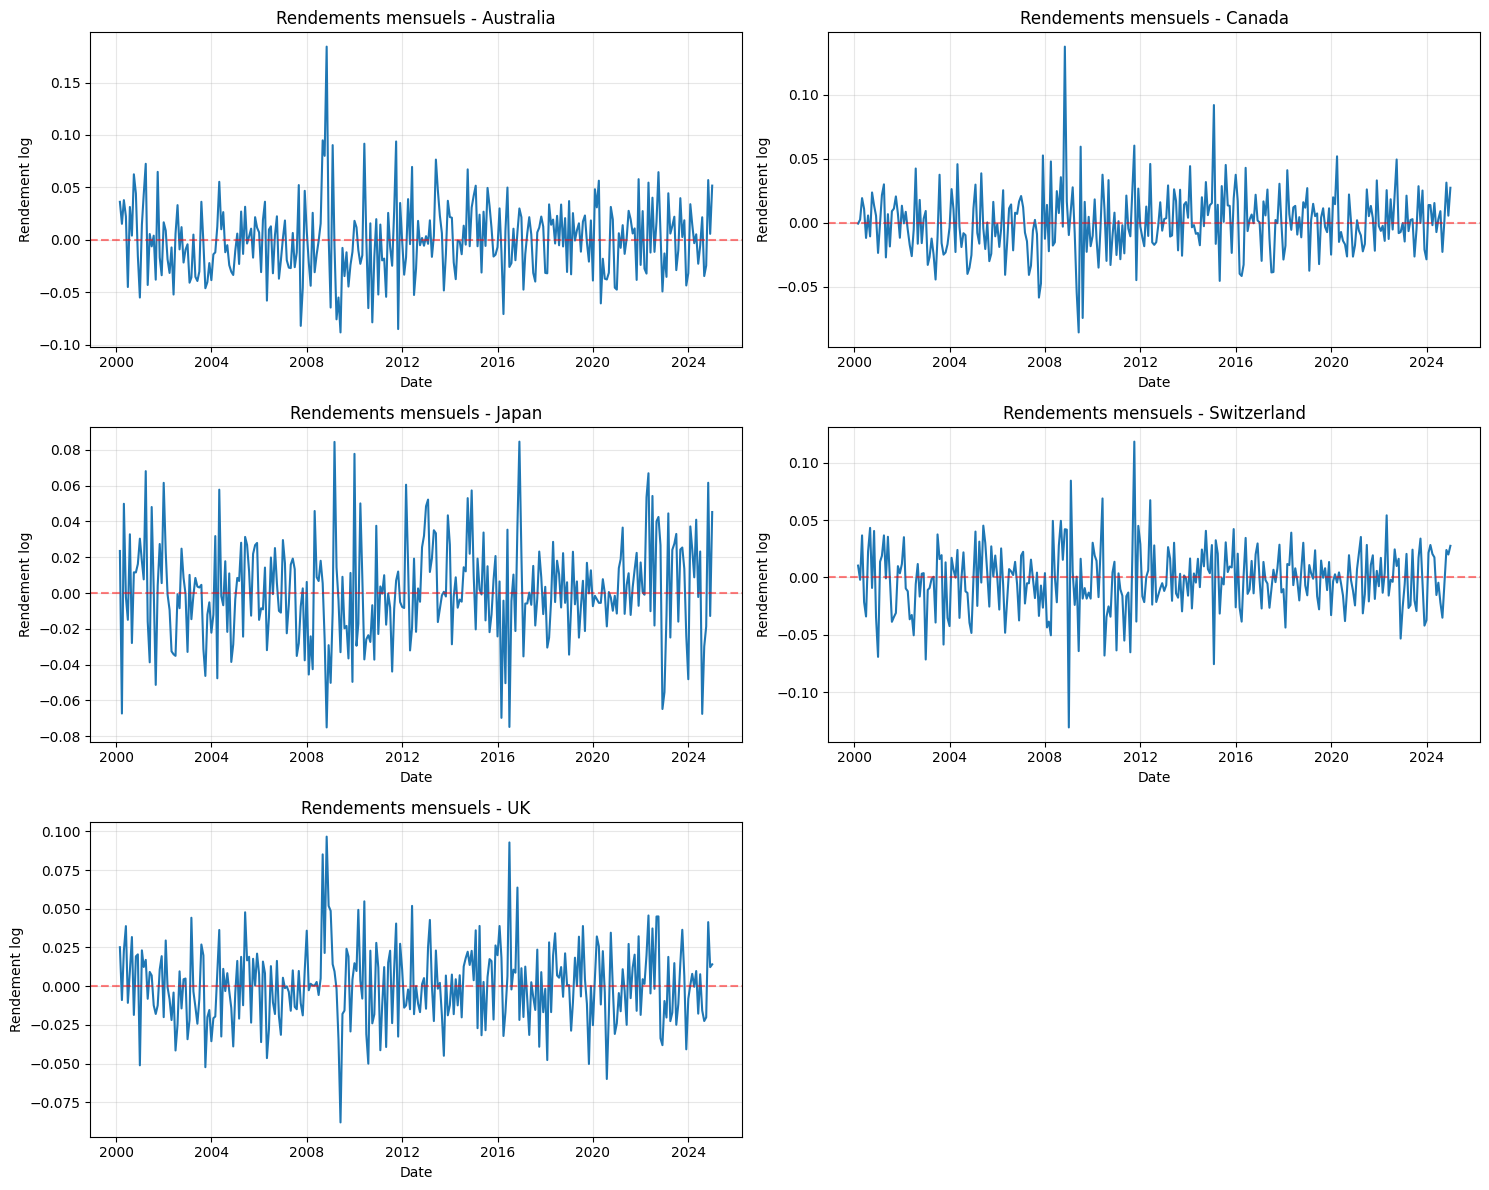

In [83]:
# Visualiser les rendements
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    axes[i].plot(returns.index, returns[col])
    axes[i].set_title(f'Rendements mensuels - {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement log')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Masquer le dernier subplot (6ème)
axes[5].axis('off')

plt.tight_layout()
plt.show()

## Préparation des données FACTORIELLES